## Binary logistic regression

Written by Jess Breda July 2023

In [170]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import seaborn as sns

Steps
-----
1. generate the dataset
2. Define cost & gradient fx
3. Initialize weights & run optimization
4. Visualize

## Dimensions & Assumptions

$ W \in (D + 1) \text{ x } C $

$ X \in N \text{ x } (D + 1) $

$ Y \in N \text{ x } C $

where

$ D = \text{number of features}$

$ C = \text{number of classes}$

$ N = \text {number of samples (i.e trials)}$

Note $W = C$ (not $C-1$), due to future assumptions about Psytrack $\sigma_c$ updates. This allows for independent sigmas. Perhaps hit and miss ($\sigma_{1}, \sigma_{2}$), have smilar sigmas but violations ($\sigma_3$), do not.

Using the Murphy text as a guide, note that $logits = X \cdot W = A$.


### 1. Generate Data

In [171]:
def softmax(logits):
    # use log-sum-exp for numerical stability
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))

    # sum over classes & normalize
    sum_exp = np.sum(exp_logits, axis=1, keepdims=True)
    return exp_logits / sum_exp


def plot_weights_multi_class(true_W, optimized_W):
    """
    Plot the true and optimized weights for each class.
    """
    # dimensions
    D_w_bias = true_W.shape[0]
    C = true_W.shape[1]

    # labels / colors
    feature_and_bias_labels = np.arange(D_w_bias)
    colors = sns.color_palette("rocket", n_colors=C).as_hex()

    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    for c in range(C):
        ax.plot(
            feature_and_bias_labels,
            true_W[:, c],
            label=f"true {c+1}",
            color=colors[c],
            marker="o",
        )
        ax.plot(
            feature_and_bias_labels,
            optimized_W[:, c],
            label=f"optimized {c+1}",
            color=colors[c],
            marker="o",
            linestyle="dashed",
        )
    _ = ax.set_xticks(feature_and_bias_labels)
    ax.set(xlabel="Feature", ylabel="Weight", title="Recovered Weights")
    ax.legend()

In [172]:
N = 10000  # Number of samples
D = 4  # Number of features
C = 3  # Number of classes

# Generate random feature values
X = np.random.randn(N, D)
X_with_bias = np.c_[np.ones(N), X]  # bias column

# Generate random true weights (including the bias coefficient)
true_W = np.random.rand(D + 1, C)

# Generate target labels (on hot encoded) using multinomial logistic function
A = X_with_bias @ true_W
P = softmax(A)
Y = np.array([np.random.multinomial(1, n) for n in P])

print(f"Generated {N} samples with {D} features and {C} classes")
print(f"W is {true_W.shape} \nX is {X_with_bias.shape} \nY is {Y.shape}")

Generated 10000 samples with 4 features and 3 classes
W is (5, 3) 
X is (10000, 5) 
Y is (10000, 3)


### 2. Define cost & gradient functions

Note, for the long term goal of applying to psytrack, keeping W = K weights These are passed into scipys' `minimize` function. Note $X$ includes a first bias column of 1s and $y_{ic}$ is one-hot encoded.

1. Probabilities given softmax

$$ p_{ic} = \frac{\exp(a_{ic})}{\sum_{j=1} ^{C}\exp(a_{ij})} $$
$$ a_{ic} = x_i \cdot w_c $$

2. Cost Function:

$$ \text{{nll}} = -\sum_{i=1} ^{N}\sum_{c=1} ^{C}y_{ic} a_{ic} + \log(\sum_{j=1} ^{C}\exp(a_{ij}))$$
$$ \text{{nll}} = -\sum_{i=1} ^{N}\sum_{c=1} ^{C}y_{ic} \log(p_{ic}) $$

3. Gradient

$$\nabla \text{nll}_W = -\sum_{i=1} ^{N}(p_{ic} - y_{ic})x_i$$




In [187]:
def multiclass_logistic_cost(W, X, Y):
    """
    Compute the negative log-likelihood for multi-class
    logistic regression.

    params:
    ------
    W: Weights matrix of shape (D+1, C)
    X: Data matrix of shape (N, D+1)
    Y: One-hot encoded labels of shape (N, C)

    Returns:
    - nll: Negative log-likelihood of shape (C, )
    """
    A = X @ W  # logits
    P = softmax(A)  # probabilites, note softmax is using log-sum-exp
    nll = -np.sum(Y * np.log(P))
    return nll


def multiclass_logistic_gradient(W, X, Y):
    """
    Compute the gradient of the negative log-likelihood for
    multi-class logistic regression.

    params:
    ------
    W: Weights matrix of shape (D+1, C)
    X: Data matrix of shape (N, D+1)
    Y: One-hot encoded labels of shape (N, C)

    Returns:
    - gradient : Gradient of shape (D+1, C)
    """
    A = X @ W  # logits
    P = softmax(A)  # probabilites, note softmax is using log-sum-exp
    gradient = X.T @ (P - Y)
    return gradient


def compute_numerical_gradient(func, W, epsilon=1e-5):
    """
    Compute the numerical gradient of a function using the two-point formula.

    params
    ------
    func: The function to compute the gradient for.
    W: Point to compute the gradient at.
    epsilon: A small perturbation value for computing the gradient.

    returns
    -------
    gradient: Numerical gradient matrix.
    """
    num_grad = np.zeros_like(W)
    perturb = np.zeros_like(W)
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            perturb[i, j] = epsilon
            loss1 = func(W - perturb)
            loss2 = func(W + perturb)
            num_grad[i, j] = (loss2 - loss1) / (2 * epsilon)
            perturb[i, j] = 0

    return num_grad


# Compute the analytical gradient using the provided function
analytical_gradient = multiclass_logistic_gradient(true_W, X_with_bias, Y)

# Compute the numerical gradient for the cost function
numerical_gradient = compute_numerical_gradient(
    lambda W: multiclass_logistic_cost(W, X_with_bias, Y), true_W
)

# Calculate the difference between the analytical and numerical gradients
gradient_difference = np.linalg.norm(analytical_gradient - numerical_gradient)
print(f"gradient_difference is {gradient_difference:.2e}")

gradient_difference is 2.91e-07


In [161]:
# wrapper functions since minimize() needs a flat W vector
def cost_function_to_minimize(W_flat, X, Y):
    W_matrix = W_flat.reshape(D + 1, C)
    return multiclass_logistic_cost(W_matrix, X, Y)


def gradient_function_to_minimize(W_flat, X, Y):
    W_matrix = W_flat.reshape(D + 1, C)
    grad_matrix = multiclass_logistic_gradient(W_matrix, X, Y)
    return grad_matrix.flatten()

### 3. Initialize Weights & Optimize

L-BFGS-B versus L-BFGS versus BFGS.

**BFGS:** is a quasi-newton method used for optimization that avoids the costly computation of the Hessian. It approximates the inverse Hessian via gradient updates.

**L-BFGS**: is the limited-memory version of BFGS, doesn't store the full Hessian matrix (or inverse), but instead a subset of vectors that represent this matrix

**L-BFGS-B**: is limited memory version + "bounds". You can implemented bound constraints on the variables being optimized to help minimized the search space. If this is implemented without the `bounds` argument, it is the same as L-BFGS.

In [174]:
# Initial weights
initial_W_flat = np.zeros((D + 1) * C)

# Optimization using L-BFGS-B
result = minimize(
    fun=cost_function_to_minimize,
    x0=initial_W_flat,
    args=(X_with_bias, Y),
    method="BFGS",
    jac=gradient_function_to_minimize,
    options={"disp": True, "maxiter": 10000},
)
optimized_W = result.x.reshape(D + 1, C)

Optimization terminated successfully.
         Current function value: 10188.154467
         Iterations: 21
         Function evaluations: 33
         Gradient evaluations: 33


In [175]:
# summarize the result
print("Status : %s" % result["message"])
print("Total Evaluations: %d" % result["nfev"])

Status : Optimization terminated successfully.
Total Evaluations: 33


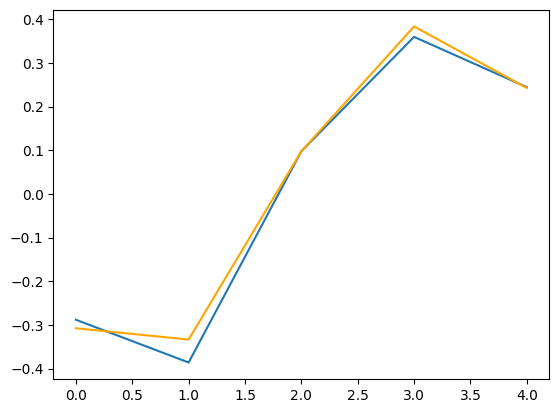

In [185]:
plt.plot(true_W[:, 0] - true_W[:, 1])
plt.plot(optimized_W[:, 0] - optimized_W[:, 1], color="orange")

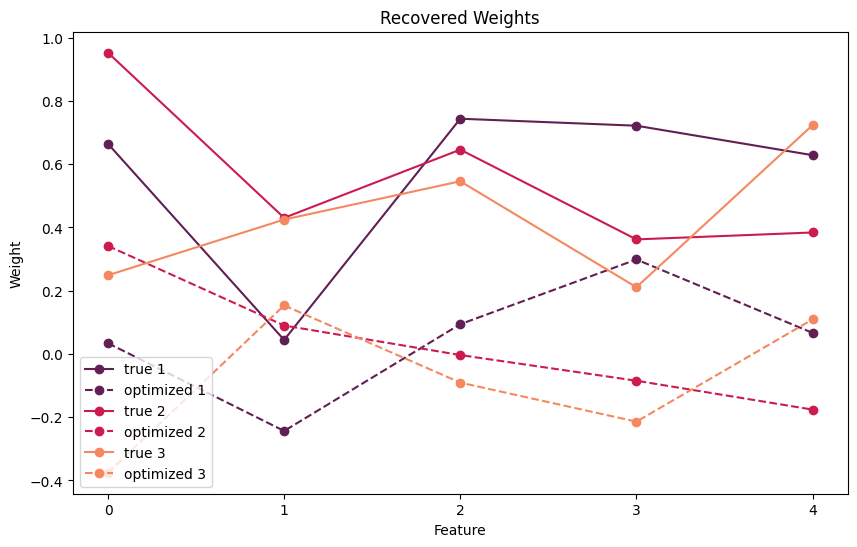

In [177]:
plot_weights_multi_class(true_W, optimized_W)

In [179]:
multiclass_logistic_cost(true_W, X_with_bias, Y)

10195.82809819462

In [176]:
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 10188.15446702455
        x: [ 3.397e-02  3.416e-01 ... -1.760e-01  1.093e-01]
      nit: 21
      jac: [-5.248e-08  2.934e-08 ...  6.930e-07 -2.716e-07]
 hess_inv: [[ 3.336e-01  3.333e-01 ... -8.484e-06  2.668e-05]
            [ 3.333e-01  3.335e-01 ...  4.144e-06  4.257e-06]
            ...
            [-8.484e-06  4.144e-06 ...  3.335e-01  3.332e-01]
            [ 2.668e-05  4.257e-06 ...  3.332e-01  3.336e-01]]
     nfev: 33
     njev: 33